#  RNN for POS-tagging problem

So, in this series we will try to use neural nets, in particular recurrent neural network to solve POS-tagging problem.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [2]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /Users/chess1812/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/chess1812/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
from nltk.corpus import brown
sents = list(brown.tagged_sents(tagset='universal'))

##  Preprocessing

Just like last time, let's preprocess our data. 

In [4]:
sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [5]:
tags = set()

for sent in sents:
    for (word, tag) in sent: 
        tags.add(tag)   
        
NUM_CLASSES = len(tags)                
print(f'tag types: {tags}')

tag types: {'CONJ', 'VERB', 'ADJ', 'NUM', 'X', 'DET', 'PRT', 'NOUN', '.', 'ADP', 'PRON', 'ADV'}


Split data on train and test

In [6]:
from sklearn.model_selection import train_test_split
sents_train, sents_test = train_test_split(sents, test_size=0.2, random_state=42)

separete words from tags:

In [7]:
tags_train = []
words_train = []
for sent in sents_test:
    tags_sent = []
    words_sent = []
    for (word, tag) in sent:
        tags_sent.append(tag)
        words_sent.append(word)
    words_train.append(words_sent)
    tags_train.append(tags_sent)

In [8]:
tags_test = []
words_test = []
for sent in sents_test:
    tags_sent = []
    words_sent = []
    for (word, tag) in sent:
        tags_sent.append(tag)
        words_sent.append(word)
    words_test.append(words_sent)
    tags_test.append(tags_sent)

In this work, we will use Keras framework. But Keras works with numbers, therefore we need to transform our words into numbers. To do that we will give each word in vocab an index and then we will replace words by their index.

In [9]:
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()             
word_tokenizer.fit_on_texts(words_train)         

X_train = word_tokenizer.texts_to_sequences(words_train)
X_test =  word_tokenizer.texts_to_sequences(words_test)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(tags_train)

y_train = tag_tokenizer.texts_to_sequences(tags_train)
y_test = tag_tokenizer.texts_to_sequences(tags_test)

# look at first encoded data point
print(" Encoded data  example: \n")
print('X: ', X_train[0], '\n')
print('y: ', y_train[0], '\n')

 Encoded data  example: 

X:  [275, 1066, 525] 

y:  [6, 1, 1] 



Also, the sentences in the corpus are not of the same length. Before we feed the input in the RNN model we need to fix the length of the sentences. We cannot dynamically allocate memory required to process each sentence in the corpus as they are of different lengths. 

Text(0.5, 1.0, 'sentence len distibution')

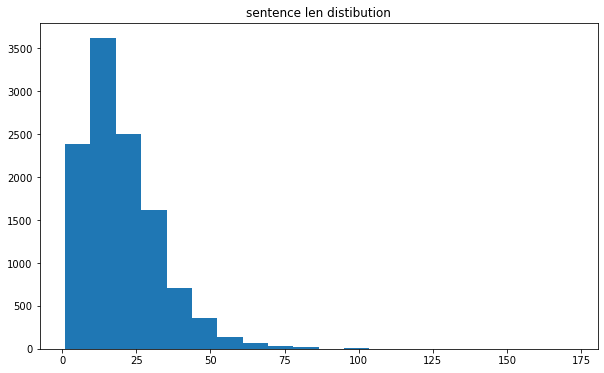

In [10]:
lens = [len(x) for x in X_train]
plt.figure(figsize = (10,6))
plt.hist(lens, bins =20)
plt.title('sentence len distibution')

So, let's assume that sentence is no longer than 100.  

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LENGTH = 100

X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
y_train = pad_sequences(y_train, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
y_test = pad_sequences(y_test, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

print('first sequence: ' )
print('X: ',X_train[0], "\n")
print('y: ',y_train[0])

first sequence: 
X:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  275
 1066  525] 

y:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 1 1]


In [12]:
VOCABULARY_SIZE = np.max(X_train) + 1

Use one-hot encoding for output sequences

In [13]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Vanilla RNN

Let’s build the RNN model.

In [14]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")
EMBEDDING_SIZE = 300

In [15]:
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
not_in_embed = 0
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = embeddings[word]
    except KeyError:
        not_in_embed += 1
        
print("number of words which don't have embedding = ", not_in_embed)

number of words which don't have embedding =  3082


In [16]:
from tensorflow.keras import layers, Sequential

def create_rnn_model(rnn_layer, embeddings = None, train_embedding = True):
    rnn_model = Sequential()
    rnn_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE, 
                                   output_dim = EMBEDDING_SIZE, 
                                   input_length = MAX_SEQ_LENGTH, 
                                   trainable = train_embedding,   # True — update the embeddings  
                                   weights = [embedding_weights] if embedding_weights is not None else None
                                   ))

    rnn_model.add(rnn_layer)
    rnn_model.add(layers.TimeDistributed(layers.Dense(NUM_CLASSES + 1, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    return rnn_model
    
    

First model is just simple RNN. But there are some ways for using embedding. We may train embeddings along with RNN layer or use pre-trained embeddings. So, as usual, let's try different  approaches and choose the best. 

In [17]:
rnn_simple = create_rnn_model(rnn_layer = layers.SimpleRNN(64, return_sequences = True))
rnn_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          6849000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100, 64)           23360     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 13)           845       
Total params: 6,873,205
Trainable params: 6,873,205
Non-trainable params: 0
_________________________________________________________________


In [18]:
rnn_simple = rnn_simple.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
180/180 [==============================] - 25s 137ms/step - loss: 0.3497 - acc: 0.9320 - val_loss: 0.0686 - val_acc: 0.9835
Epoch 2/10
180/180 [==============================] - 24s 135ms/step - loss: 0.0452 - acc: 0.9881 - val_loss: 0.0261 - val_acc: 0.9930
Epoch 3/10
180/180 [==============================] - 26s 142ms/step - loss: 0.0233 - acc: 0.9930 - val_loss: 0.0177 - val_acc: 0.9947
Epoch 4/10
180/180 [==============================] - 24s 135ms/step - loss: 0.0171 - acc: 0.9945 - val_loss: 0.0140 - val_acc: 0.9957
Epoch 5/10
180/180 [==============================] - 24s 136ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0115 - val_acc: 0.9965
Epoch 6/10
180/180 [==============================] - 24s 136ms/step - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0097 - val_acc: 0.9970
Epoch 7/10
180/180 [==============================] - 24s 135ms/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0081 - val_acc: 0.9975
Epoch 8/10
180/180 [==============================] - 2

Using pre-trained embeddings.

In [19]:
rnn_with_pretrained_emb = create_rnn_model(layers.SimpleRNN(64, return_sequences = True), embeddings, False)
rnn_with_pretrained_emb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6849000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 13)           845       
Total params: 6,873,205
Trainable params: 24,205
Non-trainable params: 6,849,000
_________________________________________________________________


In [20]:
rnn_with_pretrained_emb = rnn_with_pretrained_emb.fit(
                                                    X_train, 
                                                    y_train, 
                                                    batch_size=64, 
                                                    epochs=10, 
                                                    validation_data=(X_test, y_test
                                                    ))

Epoch 1/10
180/180 [==============================] - 9s 52ms/step - loss: 0.5943 - acc: 0.8809 - val_loss: 0.3170 - val_acc: 0.9310
Epoch 2/10
180/180 [==============================] - 10s 54ms/step - loss: 0.2449 - acc: 0.9447 - val_loss: 0.1901 - val_acc: 0.9559
Epoch 3/10
180/180 [==============================] - 10s 53ms/step - loss: 0.1639 - acc: 0.9621 - val_loss: 0.1347 - val_acc: 0.9685
Epoch 4/10
180/180 [==============================] - 10s 53ms/step - loss: 0.1179 - acc: 0.9722 - val_loss: 0.1036 - val_acc: 0.9754
Epoch 5/10
180/180 [==============================] - 10s 55ms/step - loss: 0.0942 - acc: 0.9776 - val_loss: 0.0858 - val_acc: 0.9795
Epoch 6/10
180/180 [==============================] - 10s 53ms/step - loss: 0.0800 - acc: 0.9807 - val_loss: 0.0755 - val_acc: 0.9822
Epoch 7/10
180/180 [==============================] - 10s 54ms/step - loss: 0.0722 - acc: 0.9823 - val_loss: 0.0680 - val_acc: 0.9832
Epoch 8/10
180/180 [==============================] - 10s 54ms/

So, the results are worse. But what will be if we use pre-trained embeddings but allow the network to train them further. 

Let's find out!

In [21]:
rnn_with_emb = create_rnn_model(layers.SimpleRNN(64, return_sequences = True), embeddings)
rnn_with_emb.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          6849000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 13)           845       
Total params: 6,873,205
Trainable params: 6,873,205
Non-trainable params: 0
_________________________________________________________________


In [22]:
rnn_with_emb = rnn_with_emb.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
180/180 [==============================] - 24s 134ms/step - loss: 0.3644 - acc: 0.9263 - val_loss: 0.0792 - val_acc: 0.9810
Epoch 2/10
180/180 [==============================] - 25s 136ms/step - loss: 0.0500 - acc: 0.9869 - val_loss: 0.0280 - val_acc: 0.9927
Epoch 3/10
180/180 [==============================] - 24s 134ms/step - loss: 0.0245 - acc: 0.9930 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 4/10
180/180 [==============================] - 25s 138ms/step - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0142 - val_acc: 0.9956
Epoch 5/10
180/180 [==============================] - 25s 137ms/step - loss: 0.0141 - acc: 0.9955 - val_loss: 0.0116 - val_acc: 0.9965
Epoch 6/10
180/180 [==============================] - 24s 134ms/step - loss: 0.0117 - acc: 0.9963 - val_loss: 0.0096 - val_acc: 0.9971
Epoch 7/10
180/180 [==============================] - 25s 139ms/step - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0081 - val_acc: 0.9977
Epoch 8/10
180/180 [==============================] - 2

So, score is more or less the same. 

## LSTM model

Next, we’ll build an LSTM model instead of an RNN.

In [23]:
lstm_model = create_rnn_model(layers.LSTM(64, return_sequences=True), embeddings)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          6849000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 64)           93440     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 13)           845       
Total params: 6,943,285
Trainable params: 6,943,285
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm_model = lstm_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
180/180 [==============================] - 31s 173ms/step - loss: 0.5713 - acc: 0.8772 - val_loss: 0.2132 - val_acc: 0.9421
Epoch 2/10
180/180 [==============================] - 31s 174ms/step - loss: 0.1112 - acc: 0.9733 - val_loss: 0.0510 - val_acc: 0.9896
Epoch 3/10
180/180 [==============================] - 29s 164ms/step - loss: 0.0385 - acc: 0.9904 - val_loss: 0.0280 - val_acc: 0.9924
Epoch 4/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0257 - acc: 0.9922 - val_loss: 0.0218 - val_acc: 0.9929
Epoch 5/10
180/180 [==============================] - 30s 168ms/step - loss: 0.0212 - acc: 0.9929 - val_loss: 0.0187 - val_acc: 0.9937
Epoch 6/10
180/180 [==============================] - 30s 165ms/step - loss: 0.0184 - acc: 0.9937 - val_loss: 0.0164 - val_acc: 0.9945
Epoch 7/10
180/180 [==============================] - 30s 164ms/step - loss: 0.0163 - acc: 0.9943 - val_loss: 0.0145 - val_acc: 0.9951
Epoch 8/10
180/180 [==============================] - 3

## GRU model

Let’s now build a GRU model.

In [25]:
gru_model = create_rnn_model(layers.GRU(64, return_sequences=True), embeddings)
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          6849000   
_________________________________________________________________
gru (GRU)                    (None, 100, 64)           70272     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 100, 13)           845       
Total params: 6,920,117
Trainable params: 6,920,117
Non-trainable params: 0
_________________________________________________________________


In [26]:
gru_model = gru_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
180/180 [==============================] - 30s 168ms/step - loss: 0.4606 - acc: 0.9149 - val_loss: 0.0860 - val_acc: 0.9794
Epoch 2/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0521 - acc: 0.9857 - val_loss: 0.0297 - val_acc: 0.9917
Epoch 3/10
180/180 [==============================] - 29s 162ms/step - loss: 0.0265 - acc: 0.9917 - val_loss: 0.0210 - val_acc: 0.9929
Epoch 4/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0204 - acc: 0.9929 - val_loss: 0.0176 - val_acc: 0.9938
Epoch 5/10
180/180 [==============================] - 29s 161ms/step - loss: 0.0174 - acc: 0.9938 - val_loss: 0.0151 - val_acc: 0.9947
Epoch 6/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0153 - acc: 0.9946 - val_loss: 0.0133 - val_acc: 0.9954
Epoch 7/10
180/180 [==============================] - 29s 163ms/step - loss: 0.0135 - acc: 0.9952 - val_loss: 0.0118 - val_acc: 0.9959
Epoch 8/10
180/180 [==============================] - 3

Surprisingly, neither LSTM nor GRU can't improve score

## Bidirectional model

But wait, why do we use our model only  in one direction?  That is a good point, in practice bidirectional model almost always works better.


In [27]:
bidirect_model = create_rnn_model(layers.Bidirectional(layers.LSTM(64, return_sequences=True)), embeddings)
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          6849000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 100, 13)           1677      
Total params: 7,037,557
Trainable params: 7,037,557
Non-trainable params: 0
_________________________________________________________________


In [28]:
bidirect_model = bidirect_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
180/180 [==============================] - 39s 218ms/step - loss: 0.4712 - acc: 0.8901 - val_loss: 0.1272 - val_acc: 0.9666
Epoch 2/10
180/180 [==============================] - 38s 209ms/step - loss: 0.0596 - acc: 0.9851 - val_loss: 0.0273 - val_acc: 0.9934
Epoch 3/10
180/180 [==============================] - 37s 208ms/step - loss: 0.0226 - acc: 0.9941 - val_loss: 0.0162 - val_acc: 0.9956
Epoch 4/10
180/180 [==============================] - 38s 210ms/step - loss: 0.0151 - acc: 0.9956 - val_loss: 0.0120 - val_acc: 0.9966
Epoch 5/10
180/180 [==============================] - 38s 213ms/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0096 - val_acc: 0.9973
Epoch 6/10
180/180 [==============================] - 38s 214ms/step - loss: 0.0096 - acc: 0.9972 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 7/10
180/180 [==============================] - 39s 215ms/step - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0063 - val_acc: 0.9984
Epoch 8/10
180/180 [==============================] - 3

Yes, it works better!

To sum up, let's bring all results in one place. 

In [30]:
dct = {}
dct['model'] = ['Most Frequent Class','Most Frequent Class with Random forest','Hidden Markov Model',
                'Simple RNN','RNN with pre-trained embeddings','RNN with pre-trained embeddings + train',
                 'LSTM', 'GRU', 'Bidirectional LSTM']

dct['train score'] = ['95.72%', '97.36%', '97.54%', '99.82%', '98.45%', '99.83%' ,     '99.59%','99.63%' , '99.90%']
dct['test score'] = ['94.51%', '95.39%', '96.02%', '99.87%', '98.51%', '99.87%', '99.65%', '99.70%', '99.93%']





df = pd.DataFrame(data=dct)
df

,model,train score,test score
0,Most Frequent Class,95.72%,94.51%
1,Most Frequent Class with Random forest,97.36%,95.39%
2,Hidden Markov Model,97.54%,96.02%
3,Simple RNN,99.82%,99.87%
4,RNN with pre-trained embeddings,98.45%,98.51%
5,RNN with pre-trained embeddings + train,99.83%,99.87%
6,LSTM,99.59%,99.65%
7,GRU,99.63%,99.70%
8,Bidirectional LSTM,99.90%,99.93%


**Conclusion**

Recurrent neural networks  provide the opportunity solve the problems such as pos-tagging more effectively. Also it should not to be forgotten if you have opportunity to use bidirectional RNN you have to do that! 
But as usual, the best way to understand whether idea works or not is just try it! 